2025-06-08 13:19:05,646 - INFO - --- Section 1: Simulating Input Data ---
2025-06-08 13:19:05,679 - INFO - Simulated 50 samples.
2025-06-08 13:19:05,680 - INFO - Raw Transcriptomics shape: (50, 1000) (Samples x Total Genes)
2025-06-08 13:19:05,681 - INFO - Raw Proteomics shape: (50, 800) (Samples x Total Proteins)
2025-06-08 13:19:05,681 - INFO - Number of features intended to be matched: 500
2025-06-08 13:19:05,682 - INFO - --- Section 2: Matching Transcriptomic and Proteomic Features ---
2025-06-08 13:19:05,695 - INFO - Matched transcriptomics shape: (50, 500) (Samples x Matched Genes)
2025-06-08 13:19:05,696 - INFO - Matched proteomics shape: (50, 500) (Samples x Matched Proteins)
2025-06-08 13:19:05,696 - INFO - --- Section 3: Simulating Pathway Data ---
2025-06-08 13:19:05,697 - INFO - Simulated 20 pathways covering the matched genes.
2025-06-08 13:19:05,697 - INFO - --- Section 4: Creating Pathway Tiling Master Map ---
2025-06-08 13:19:05,699 - INFO - Target grid dimensions: 23 (

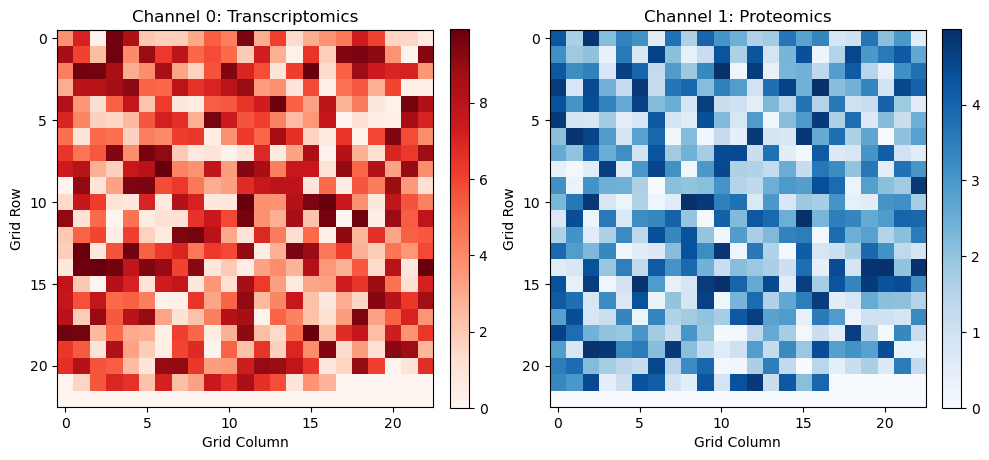

2025-06-08 13:19:08,584 - INFO - --- Script Execution Finished ---


: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# import gseapy # For actual pathway data if needed, can be installed via pip

import torch
import torch.nn as nn # Neural network modules
import torch.optim as optim # Optimization algorithms
from torch.utils.data import Dataset, DataLoader # For handling datasets and creating batches

import logging # For logging progress and errors
import sys # For flushing stdout for logs in some environments, ensuring logs appear promptly

# --- 0. Setup Logging ---
# Configure basic logging settings to display messages with timestamps, log level, and the message itself.
# This helps in tracking the script's execution and debugging.
logging.basicConfig(
    level=logging.INFO, # Set the minimum log level to INFO (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s', # Define the format of log messages
    handlers=[
        logging.StreamHandler(sys.stdout) # Output logs to the standard output (console)
    ]
)
logger = logging.getLogger(__name__) # Get a logger instance for this script

# --- 1. Load and Prepare Data (Simulation) ---
logger.info("--- Section 1: Simulating Input Data ---")
# Define parameters for data simulation
num_samples = 50 # Number of individuals/samples in our dataset
num_genes_total = 1000 # Total number of unique genes measured in transcriptomics
num_proteins_total = 800 # Total number of unique proteins measured in proteomics
num_matched_features = 500 # Number of features (gene/protein pairs) common to both omics types that we'll use

# Set random seeds for reproducibility of simulated data
np.random.seed(42)
torch.manual_seed(42) # PyTorch random seed

# Create dummy sample names
sample_names = [f'Sample_{i+1}' for i in range(num_samples)]

# Create dummy gene and protein identifiers
all_genes = [f'Gene_{i+1}' for i in range(num_genes_total)] # List of all gene IDs
# Define the list of gene IDs that will have corresponding protein data
matched_ids = [f'Gene_{i+1}' for i in range(num_matched_features)]

# Create full list of transcriptomic features (genes)
transcript_ids = matched_ids + [f'Gene_{i+1}' for i in range(num_matched_features, num_genes_total)]
# Create full list of proteomic features (proteins). For matched features, protein ID = gene ID.
# For non-matched proteins, they get a 'Prot_' prefix.
protein_col_ids = matched_ids + [f'Prot_{i+1}' for i in range(num_matched_features, num_proteins_total)]

# Simulate Transcriptomic Data (Samples x Genes)
# Values are random numbers, representing e.g., expression levels.
t_data = np.random.rand(num_samples, len(transcript_ids)) * 10
transcriptomics_df = pd.DataFrame(t_data, index=sample_names, columns=transcript_ids)

# Simulate Proteomic Data (Samples x Proteins)
# Values are random numbers, representing e.g., abundance levels.
p_data = np.random.rand(num_samples, len(protein_col_ids)) * 5
proteomics_df = pd.DataFrame(p_data, index=sample_names, columns=protein_col_ids)

# Simulate Outcome Labels (e.g., Disease vs Control)
# Binary labels (0 or 1) for each sample.
labels_np = np.random.randint(0, 2, size=num_samples)

logger.info(f"Simulated {num_samples} samples.")
logger.info(f"Raw Transcriptomics shape: {transcriptomics_df.shape} (Samples x Total Genes)")
logger.info(f"Raw Proteomics shape: {proteomics_df.shape} (Samples x Total Proteins)")
logger.info(f"Number of features intended to be matched: {len(matched_ids)}")

# --- 2. Match Features ---
logger.info("--- Section 2: Matching Transcriptomic and Proteomic Features ---")
# Filter the transcriptomics and proteomics dataframes to only include the common, matched features.
# The column names for these matched features are identical in `matched_ids`.
transcriptomics_matched = transcriptomics_df[matched_ids]
# For proteomics, we also select columns based on `matched_ids` because we simulated
# protein IDs to be the same as gene IDs for the matched portion.
proteomics_matched = proteomics_df[matched_ids]

logger.info(f"Matched transcriptomics shape: {transcriptomics_matched.shape} (Samples x Matched Genes)")
logger.info(f"Matched proteomics shape: {proteomics_matched.shape} (Samples x Matched Proteins)")

# --- 3. Get Pathway Data (Simulation) ---
logger.info("--- Section 3: Simulating Pathway Data ---")
# Pathways are sets of genes that work together. We simulate this by grouping our matched gene IDs.
pathways = {} # Dictionary to store pathway_name: [gene_list]
genes_per_pathway = 25 # Arbitrary number of genes per simulated pathway
# Calculate how many pathways we need to cover all matched genes
num_pathways_sim = math.ceil(len(matched_ids) / genes_per_pathway)
current_gene_idx_for_pathway = 0 # Keep track of genes assigned to pathways
for i in range(num_pathways_sim):
    pathway_name = f'Pathway_{i+1}'
    # Get a slice of matched_ids for the current pathway
    pathway_genes = matched_ids[current_gene_idx_for_pathway : current_gene_idx_for_pathway + genes_per_pathway]
    if pathway_genes: # Ensure the list is not empty
        pathways[pathway_name] = pathway_genes
    current_gene_idx_for_pathway += genes_per_pathway
logger.info(f"Simulated {len(pathways)} pathways covering the matched genes.")

# --- 4. Create Pathway Tiling Master Map ---
logger.info("--- Section 4: Creating Pathway Tiling Master Map ---")
# This map defines where each gene/protein pair will be placed on a 2D grid.
# The grid dimensions are chosen to be roughly square and large enough to hold all matched features.
grid_h = int(math.ceil(math.sqrt(len(matched_ids)))) # Height of the grid
grid_w = grid_h # Width of the grid (making it square)
grid_total_pixels = grid_h * grid_w
logger.info(f"Target grid dimensions: {grid_h} (H) x {grid_w} (W) = {grid_total_pixels} pixels")

# `gene_to_position` will store the (row, col) for each gene ID on the grid.
# This mapping MUST be THE SAME for ALL samples.
gene_to_position = {}
current_row, current_col = 0, 0 # Start placing from top-left (0,0)

# Sort pathway names for consistent ordering of tiles
sorted_pathway_names = sorted(pathways.keys())
genes_placed_count = 0 # Counter for genes successfully placed on the grid

# Iterate through pathways and then genes within each pathway to assign positions
for pathway_name in sorted_pathway_names:
    pathway_genes = pathways[pathway_name]
    # Sort genes within the pathway for consistent placement within the tile
    sorted_genes_in_pathway = sorted(pathway_genes)

    for gene_id in sorted_genes_in_pathway:
        # Ensure the gene is one of our matched features and hasn't been placed already
        # (handles potential gene overlap in real pathway data, though not in this simulation)
        if gene_id in matched_ids and gene_id not in gene_to_position:
            if current_row < grid_h: # Check if there's still space in the grid
                gene_to_position[gene_id] = (current_row, current_col)
                genes_placed_count +=1
                
                # Move to the next pixel position (fill row by row)
                current_col += 1
                if current_col >= grid_w: # If end of row reached
                    current_col = 0 # Reset column to start
                    current_row += 1 # Move to next row
            else:
                # This should ideally not happen if grid_total_pixels >= len(matched_ids)
                logger.warning(f"Grid full ({grid_h}x{grid_w}). Cannot place gene {gene_id} from {pathway_name}.")
                break # Stop placing genes from this pathway
    if current_row >= grid_h:
         logger.warning("Grid completely full. Stopping pathway tiling.")
         break # Stop iterating through pathways if grid is full

logger.info(f"Placed {genes_placed_count} unique genes onto the {grid_h}x{grid_w} grid.")
if genes_placed_count < len(matched_ids):
     # This indicates an issue in tiling logic or grid size if not all matched genes were placed.
     logger.warning(f"ALERT: Not all matched genes ({len(matched_ids)}) could be placed. Only {genes_placed_count} were mapped.")


# --- 5. Generate 2-Channel Images for Each Sample ---
logger.info("--- Section 5: Generating 2-Channel 'Biological Images' ---")
# Each sample will be converted into a 2-channel image (H x W x C, then permuted to C x H x W).
# Channel 0: Transcriptomics, Channel 1: Proteomics.
all_sample_images_np = [] # List to store the generated images as NumPy arrays
fill_value = 0.0 # Value for pixels not corresponding to a gene or if data is missing

for sample_idx, sample_name in enumerate(sample_names):
    # Initialize two empty channels (grids) for the current sample
    channel_T = np.full((grid_h, grid_w), fill_value, dtype=np.float32) # Transcriptomics channel
    channel_P = np.full((grid_h, grid_w), fill_value, dtype=np.float32) # Proteomics channel

    # Get the row of data for the current sample from the matched dataframes
    t_sample_data = transcriptomics_matched.loc[sample_name]
    p_sample_data = proteomics_matched.loc[sample_name]

    # Populate the channels using the `gene_to_position` master map
    for gene_id, (r, c) in gene_to_position.items():
        # Place transcriptomic value if gene_id exists in the sample's data
        if gene_id in t_sample_data:
            channel_T[r, c] = t_sample_data[gene_id]
        # Place proteomic value if gene_id (protein_id) exists in the sample's data
        if gene_id in p_sample_data: # Recall protein columns also use gene_id for matched features
            channel_P[r, c] = p_sample_data[gene_id]
    
    # Stack the two channels. PyTorch's nn.Conv2d expects input as (N, C, H, W).
    # So, for a single sample, the channel dimension (C) should come before H and W.
    sample_image_chw = np.stack([channel_T, channel_P], axis=0) # Shape: (2, H, W)
    all_sample_images_np.append(sample_image_chw)

# Convert the list of images into a single NumPy array
# This array will have shape (Number of Samples, Channels, Height, Width)
cnn_input_data_np = np.array(all_sample_images_np)
logger.info(f"Generated CNN input data (NumPy array) with shape: {cnn_input_data_np.shape} (N, C, H, W)")

# --- 6. Create PyTorch Dataset and DataLoader ---
logger.info("--- Section 6: Creating PyTorch Dataset and DataLoader ---")

# Custom Dataset class to wrap our image data and labels
class OmicsImageDataset(Dataset):
    """
    Custom PyTorch Dataset for omics image data.
    Converts NumPy arrays to PyTorch tensors.
    """
    def __init__(self, images_np_array, labels_np_array):
        # Convert images and labels to PyTorch tensors upon initialization
        # Images are expected in (N, C, H, W) format from NumPy
        self.images = torch.tensor(images_np_array, dtype=torch.float32)
        # Labels need to be shaped correctly for the loss function (e.g., BCEWithLogitsLoss expects (N, 1))
        self.labels = torch.tensor(labels_np_array, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        # Returns the total number of samples in the dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Returns the image and label for a given index `idx`
        return self.images[idx], self.labels[idx]

# For a real scenario, split data into training, validation, (and test) sets
# from sklearn.model_selection import train_test_split
# X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(cnn_input_data_np, labels_np, test_size=0.2, random_state=42)
# train_dataset = OmicsImageDataset(X_train_np, y_train_np)
# val_dataset = OmicsImageDataset(X_val_np, y_val_np)

# For this demonstration, we use all data for training.
train_dataset = OmicsImageDataset(cnn_input_data_np, labels_np)

# DataLoader provides an iterator over the dataset, handling batching, shuffling, and parallel loading.
batch_size_train = 16 # Number of samples per batch
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

logger.info(f"PyTorch DataLoader created. Number of training batches: {len(train_dataloader)} with batch size {batch_size_train}")

# To inspect a batch:
# images_batch_example, labels_batch_example = next(iter(train_dataloader))
# logger.info(f"Shape of a sample batch of images: {images_batch_example.shape}") # Expected: (batch_size, C, H, W)
# logger.info(f"Shape of a sample batch of labels: {labels_batch_example.shape}") # Expected: (batch_size, 1)

# --- 7. Define PyTorch CNN Model ---
logger.info("--- Section 7: Defining the PyTorch CNN Model ---")

class PathwayCNN(nn.Module):
    """
    Convolutional Neural Network for pathway-tiled omics images.
    Input: (N, C, H, W) tensor, where C=2 (transcriptomics, proteomics)
    Output: Raw logits for binary classification.
    """
    def __init__(self, input_channels, height, width):
        super(PathwayCNN, self).__init__() # Initialize the parent nn.Module class
        
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            # padding=1 with kernel_size=3 keeps H and W the same (if stride=1)
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1), # Output: (N, 32, H, W)
            nn.ReLU(), # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # Downsamples H and W by factor of 2. Output: (N, 32, H/2, W/2)
            # nn.BatchNorm2d(32) # Optional: Batch Normalization layer
        )
        # Calculate spatial dimensions after first pooling layer
        h_after_pool1 = height // 2
        w_after_pool1 = width // 2

        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Input from previous block (32 channels). Output: (N, 64, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Downsamples H/2, W/2. Output: (N, 64, H/4, W/4)
            # nn.BatchNorm2d(64) # Optional
        )
        # Calculate spatial dimensions after second pooling layer
        h_after_pool2 = h_after_pool1 // 2
        w_after_pool2 = w_after_pool1 // 2
        
        # Flatten layer to convert 3D feature maps (C_out, H_pooled, W_pooled) into a 1D vector
        self.flatten = nn.Flatten()
        
        # Calculate the number of features after flattening.
        # This is crucial for defining the input size of the first fully connected (Linear) layer.
        # Add a safeguard for very small input H, W which might become 0 after pooling.
        if h_after_pool2 < 1 or w_after_pool2 < 1:
            logger.error(f"Grid dimensions ({height}x{width}) are too small for two max pooling layers, resulting in zero dimension after pooling.")
            # This is a critical error. The model cannot be built correctly.
            # For demonstration, we'll try to make it work with min dimension 1, but this needs careful review.
            self.num_flattened_features = 64 * max(1, h_after_pool2) * max(1, w_after_pool2)
            if h_after_pool2 < 1 or w_after_pool2 < 1:
                 logger.warning(f"Adjusted flattened features to {self.num_flattened_features} due to post-pool dimensions being < 1. Review model architecture or grid size.")
        else:
            self.num_flattened_features = 64 * h_after_pool2 * w_after_pool2

        # Fully Connected (Dense) Block for classification
        self.fc_block = nn.Sequential(
            nn.Linear(self.num_flattened_features, 128), # Input features from flattened layer, 128 output units
            nn.ReLU(),
            # nn.Dropout(0.5), # Optional: Dropout layer for regularization
            nn.Linear(128, 1) # Output layer: 1 unit for binary classification (outputs raw logits)
        )

    def forward(self, x):
        # Defines the forward pass of the model: how input `x` flows through the layers.
        x = self.conv_block1(x) # Pass through first convolutional block
        x = self.conv_block2(x) # Pass through second convolutional block
        x = self.flatten(x)     # Flatten the feature maps
        x = self.fc_block(x)    # Pass through fully connected layers
        return x # Returns raw logits

# Instantiate the model
input_channels_cnn = cnn_input_data_np.shape[1] # Number of channels (should be 2)
model = PathwayCNN(input_channels_cnn, grid_h, grid_w)
logger.info("CNN Model architecture defined:")
logger.info(model) # Print the model structure

# --- 8. Training Loop ---
logger.info("--- Section 8: Starting CNN Model Training ---")
# Determine device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device} for training.")
model.to(device) # Move the model to the selected device

# Loss Function: BCEWithLogitsLoss is suitable for binary classification.
# It combines a Sigmoid layer and Binary Cross Entropy loss in one class, offering numerical stability.
criterion = nn.BCEWithLogitsLoss() 
# Optimizer: Adam is a popular choice for adaptive learning rates.
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr is the learning rate

num_epochs = 5 # Number of times to iterate over the entire training dataset (for demonstration)

# Start the training loop
for epoch in range(num_epochs):
    model.train() # Set the model to training mode (enables dropout, batchnorm updates if used)
    running_loss_epoch = 0.0 # Accumulate loss over the epoch
    correct_predictions_epoch = 0 # Accumulate correct predictions
    total_samples_epoch = 0 # Count total samples processed in the epoch

    # Iterate over batches of data from the DataLoader
    for batch_idx, (images_batch, targets_batch) in enumerate(train_dataloader):
        # Move data and targets to the selected device
        images_batch, targets_batch = images_batch.to(device), targets_batch.to(device)

        # 1. Zero the gradients: Clear gradients from the previous step
        optimizer.zero_grad()

        # 2. Forward pass: Get model predictions (logits) for the current batch
        outputs_logits = model(images_batch)
        
        # 3. Calculate loss: Compare model predictions with actual targets
        loss = criterion(outputs_logits, targets_batch)

        # 4. Backward pass: Compute gradients of the loss with respect to model parameters
        loss.backward()

        # 5. Optimizer step: Update model parameters based on gradients
        optimizer.step()

        # Accumulate loss and calculate metrics for logging
        running_loss_epoch += loss.item() * images_batch.size(0) # loss.item() is avg loss per sample in batch
        
        # Calculate accuracy for this batch
        # Apply sigmoid to logits, then threshold at 0.5 for binary prediction
        predicted_labels = torch.sigmoid(outputs_logits) > 0.5 
        correct_predictions_epoch += (predicted_labels == targets_batch).sum().item()
        total_samples_epoch += targets_batch.size(0)

        # Log progress within the epoch (e.g., every 5 batches)
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(train_dataloader) : 
             logger.info(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Current Batch Loss: {loss.item():.4f}")
    
    # Calculate average loss and accuracy for the entire epoch
    epoch_loss_avg = running_loss_epoch / total_samples_epoch
    epoch_acc_avg = correct_predictions_epoch / total_samples_epoch
    logger.info(f"Epoch [{epoch+1}/{num_epochs}] COMPLETED. Avg Training Loss: {epoch_loss_avg:.4f}, Avg Training Accuracy: {epoch_acc_avg:.4f}")

    # --- Conceptual Validation Step ---
    # After each training epoch, you would typically evaluate on a validation set.
    # model.eval() # Set model to evaluation mode (disables dropout, batchnorm uses running stats)
    # val_loss = 0.0
    # val_correct = 0
    # val_total = 0
    # with torch.no_grad(): # Disable gradient calculations for validation
    #     for val_images, val_targets in validation_dataloader: # Assuming you have a val_dataloader
    #         val_images, val_targets = val_images.to(device), val_targets.to(device)
    #         val_outputs = model(val_images)
    #         val_batch_loss = criterion(val_outputs, val_targets)
    #         val_loss += val_batch_loss.item() * val_images.size(0)
    #         val_predicted = torch.sigmoid(val_outputs) > 0.5
    #         val_correct += (val_predicted == val_targets).sum().item()
    #         val_total += val_targets.size(0)
    # avg_val_loss = val_loss / val_total
    # avg_val_acc = val_correct / val_total
    # logger.info(f"Epoch [{epoch+1}/{num_epochs}] VALIDATION. Avg Val Loss: {avg_val_loss:.4f}, Avg Val Accuracy: {avg_val_acc:.4f}")
    # ------------------------------------

logger.info("--- Model Training Finished ---")


# --- 9. Visualize an Example Image (from NumPy array before PyTorch conversion) ---
logger.info("--- Section 9: Visualizing an Example 'Biological Image' (Sample 0) ---")
# `cnn_input_data_np` is already in (N, C, H, W) format from Section 5.
# We'll visualize the first sample (index 0).
example_image_np_chw = cnn_input_data_np[0] # Shape: (C, H, W), C=2

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Create a figure with two subplots

# Plot Transcriptomics Channel (Channel 0)
# example_image_np_chw[0, :, :] gives the first channel (H, W)
im0 = axes[0].imshow(example_image_np_chw[0, :, :], cmap='Reds', interpolation='nearest')
axes[0].set_title('Channel 0: Transcriptomics')
axes[0].set_xlabel('Grid Column')
axes[0].set_ylabel('Grid Row')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04) # Add a colorbar

# Plot Proteomics Channel (Channel 1)
# example_image_np_chw[1, :, :] gives the second channel (H, W)
im1 = axes[1].imshow(example_image_np_chw[1, :, :], cmap='Blues', interpolation='nearest')
axes[1].set_title('Channel 1: Proteomics')
axes[1].set_xlabel('Grid Column')
axes[1].set_ylabel('Grid Row')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04) # Add a colorbar

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

logger.info("--- Script Execution Finished ---")